In [ ]:
# Import 
import pandas as pd
import openai
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score  # Precision, recall, and f1 score
import matplotlib.pyplot as plt
import seaborn as sns
import locale
locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')
!pip install openai

# Introduction to the Notebook

The primary purposes of this notebook are:

- Using GTP-3 Text classifier with ada model
- Dipslay the performance metrics 


In this notebook, we will use  the Generative Pre-trained Transformer 3 (GPT-3) from OpenAI to build our text classifier. The model used is ada.

Additionally, to optimize the performance metrics, we will integrate the previously excluded development data. By merging these two files, we create a new training dataset comprising 2700 observations. Our  objective is to achieve the highest possible accuracy level. 

The confusion matrix and the perfomance metrics can be found at the end of the notebook. 


# Finetuning with openai API - ada model


In [ ]:
# Import training dataset
url_train = "https://raw.githubusercontent.com/noelopez-E4S/env_claims_detector/main/data_environmental_claims/train.jsonl"
df_train = pd.read_json(url_train, lines=True)
#df_train

# Import validation dataset
url_valid = "https://raw.githubusercontent.com/noelopez-E4S/env_claims_detector/main/data_environmental_claims/dev.jsonl"
df_valid = pd.read_json(url_valid, lines=True)
#df_valid

# Import testing dataset
url_test = "https://raw.githubusercontent.com/noelopez-E4S/env_claims_detector/main/data_environmental_claims/test.jsonl"
df_test = pd.read_json(url_test, lines=True)
#df_test

## Training data set

In [ ]:
# Renaming columns and modifying data in the training DataFrame
df_train = df_train.rename(columns={'text':'prompt','label':'completion'})
df_train['completion'] = df_train['completion'].astype(str)
df_train['prompt'] = df_train['prompt'] + '->'
df_train['completion'] = ' ' + df_train['completion'] + '.\n'

# Renaming columns and modifying data in the validation DataFrame
df_valid = df_valid.rename(columns={'text':'prompt','label':'completion'})
df_valid['completion'] = df_valid['completion'].astype(str)
df_valid['prompt'] = df_valid['prompt'] + '->'
df_valid['completion'] = ' ' + df_valid['completion'] + '.\n'

# Concatenating the training and validation DataFrames
df_train = pd.concat([df_train, df_valid],ignore_index=True)

# Saving the training DataFrame to a JSON file
df_train.to_json("training_data.json", orient='records', lines=True)


With the data correctly formatted, we can now prepare them for fine-tuning using OpenAI tools.

In [ ]:
# Preparing the data for fine-tuning using the OpenAI tools
!openai tools fine_tunes.prepare_data -f training_data.json

Analyzing...

- Your JSON file appears to be in a JSONL format. Your file will be converted to JSONL format
- Your file contains 2700 prompt-completion pairs
- Based on your data it seems like you're trying to fine-tune a model for classification
- For classification, we recommend you try one of the faster and cheaper models, such as `ada`
- For classification, you can estimate the expected model performance by keeping a held out dataset, which is not used for training
- All prompts end with suffix `->`

Based on the analysis we will perform the following actions:
- [Necessary] Your format `JSON` will be converted to `JSONL`
- [Recommended] Would you like to split into training and validation set? [Y/n]: Y


Your data will be written to a new JSONL file. Proceed [Y/n]: Y

Wrote modified files to `training_data_prepared_train.jsonl` and `training_data_prepared_valid.jsonl`
Feel free to take a look!

Now use that file when fine-tuning:
> openai api fine_tunes.create -t "training_data_pre

In the following cell, we specify that we want to train our model with ada.

In [ ]:
# Fine-tuning the model using the prepared training data
!openai --api-key '***' api fine_tunes.create -t "training_data_prepared_train.jsonl" -v "training_data_prepared_valid.jsonl" -m ada

Found potentially duplicated files with name 'training_data_prepared_train.jsonl', purpose 'fine-tune' and size 410387 bytes
file-aw4i9N9N4TtS7uKRp1BITZz9
Enter file ID to reuse an already uploaded file, or an empty string to upload this file anyway: 
Upload progress: 100% 410k/410k [00:00<00:00, 451Mit/s]
Uploaded file from training_data_prepared_train.jsonl: file-N5jfzXQcesVvQX3Jr5xRPPK4
Found potentially duplicated files with name 'training_data_prepared_valid.jsonl', purpose 'fine-tune' and size 101194 bytes
file-0SxkL6Ej9P4o9aDfuTJIOt7O
Enter file ID to reuse an already uploaded file, or an empty string to upload this file anyway: 
Upload progress: 100% 101k/101k [00:00<00:00, 160Mit/s]
Uploaded file from training_data_prepared_valid.jsonl: file-cMBWX1xzSAJJppbpBsQvk00f
Created fine-tune: ft-9OJ1SeWvQHDuXxIEPuzh8Olt
Streaming events until fine-tuning is complete...

(Ctrl-C will interrupt the stream, but not cancel the fine-tune)
[2023-05-20 17:15:59] Created fine-tune: ft-9OJ1SeW

In [ ]:
 # Following the fine-tuning process to train the model further
 !openai --api-key '***' api fine_tunes.follow -i ft-9OJ1SeWvQHDuXxIEPuzh8Olt

[2023-05-20 17:15:59] Created fine-tune: ft-9OJ1SeWvQHDuXxIEPuzh8Olt
[2023-05-20 17:19:40] Fine-tune costs $0.12
[2023-05-20 17:19:40] Fine-tune enqueued. Queue number: 0
[2023-05-20 17:19:42] Fine-tune started
[2023-05-20 17:23:28] Completed epoch 1/4
[2023-05-20 17:26:58] Completed epoch 2/4
[2023-05-20 17:30:28] Completed epoch 3/4
[2023-05-20 17:33:58] Completed epoch 4/4
[2023-05-20 17:34:23] Uploaded model: ada:ft-personal-2023-05-20-17-34-23
[2023-05-20 17:34:24] Uploaded result file: file-J3UCuqZlpQJX08yNmp5D4BN6
[2023-05-20 17:34:24] Fine-tune succeeded

Job complete! Status: succeeded 🎉
Try out your fine-tuned model:

openai api completions.create -m ada:ft-personal-2023-05-20-17-34-23 -p <YOUR_PROMPT>


## Testing data set

After training the model on the training dataset, our goal is to predict the sentences in the testing dataset. However, before proceeding with these predictions, we have to reformat the testing dataset to make it compatible with the model.

In [ ]:
# Renaming columns and modifying data in the test DataFrame
df_test = df_test.rename(columns={'text':'prompt','label':'completion'})
df_test['completion'] = df_test['completion'].astype(str)
df_test['prompt'] = df_test['prompt'] + '->'
df_test['completion'] = ' ' + df_test['completion'] + '.\n'

,prompt,completion
0,I don't know what the economic bumps are going...,0.\n
1,2 oven that will almost deliver as good as a p...,0.\n
2,"And so certainly, we have a lot of cost saving...",0.\n
3,So it's only in back half as we continue our e...,0.\n
4,We have worked hard to make real energy effici...,0.\n
...,...,...
295,"Focused on our waste combustion technologies, ...",0.\n
296,As a responsible business Adani Group is commi...,0.\n
297,Structural works on The Foundry (Building 2) a...,0.\n
298,The carbon footprint per unit of GDP of the so...,0.\n


In [ ]:
# Set the OpenAI API key using the API key
api_key = '***'
openai.api_key = api_key

In [ ]:
# Make predictions for each sentence
predictions = []
for index, row in df_test.iterrows():
    new_prompt = row["prompt"]
    answer = openai.Completion.create(
        model="ada:ft-personal-2023-05-20-17-34-23",
        prompt=new_prompt,
        max_tokens=2,  # Adjust based on your desired prediction length
        temperature=0
    )
    difficulty = answer.choices[0]['text']
    predictions.append(difficulty)

# Add the predictions to the dataframe
df_test["pred"] = predictions

In [ ]:
# Modifying data in the test DataFrame
df_test['completion'] = df_test['completion'].str.replace('\n', '')
df_test['completion'] = df_test['completion'].str.replace('.', '')
df_test['pred'] = df_test['pred'].str.replace('.', '')
df_test

<ipython-input-57-33f1fe2fc88e>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_test['completion'] = df_test['completion'].str.replace('.', '')
<ipython-input-57-33f1fe2fc88e>:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_test['pred'] = df_test['pred'].str.replace('.', '')


,prompt,completion,pred
0,I don't know what the economic bumps are going...,0,0
1,2 oven that will almost deliver as good as a p...,0,0
2,"And so certainly, we have a lot of cost saving...",0,0
3,So it's only in back half as we continue our e...,0,0
4,We have worked hard to make real energy effici...,0,0
...,...,...,...
295,"Focused on our waste combustion technologies, ...",0,0
296,As a responsible business Adani Group is commi...,0,0
297,Structural works on The Foundry (Building 2) a...,0,0
298,The carbon footprint per unit of GDP of the so...,0,0


In [ ]:
# Saving the modified test DataFrame to a CSV file
df_test.to_csv('df_test_ada.csv', index=False)

In [ ]:
# Converting the completion and prediction columns in the test DataFrame to integers so that our labels are integers, not strings --> to compute metrics
y_test = df_test['completion'].astype(int)
y_pred = df_test['pred'].astype(int)

The accuracy using ada is: 88.33%
The precision using ada is: 69.33%
The recall using ada is: 81.25%


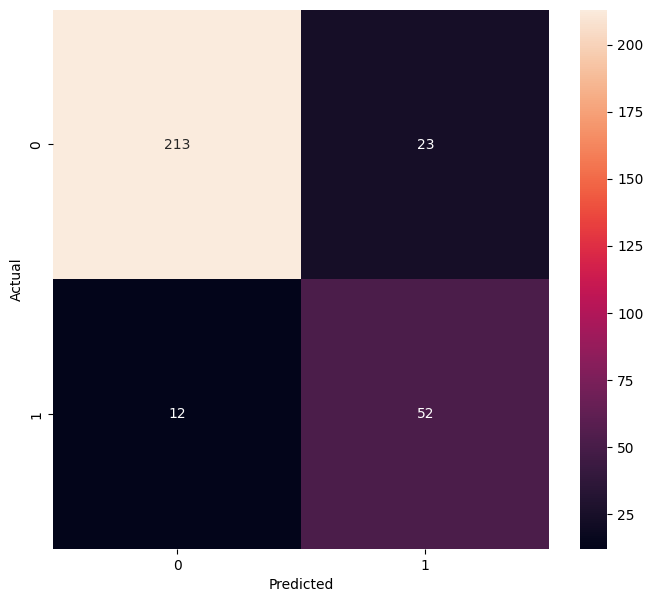

In [ ]:
# Evaluate model
accuracy = round(accuracy_score(y_test, y_pred), 4)
precision = round(precision_score(y_test, y_pred), 4)
recall = round(recall_score(y_test, y_pred), 4)
print(f'The accuracy using ada is: {accuracy*100:0.2f}%')
print(f'The precision using ada is: {precision*100:0.2f}%')
print(f'The recall using ada is: {recall*100:0.2f}%')

# Confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,7))
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show() 

When comparing the previous model developed in the main notebook model_prediction.ipynb, the use of GPT-3 Text classifier with ada model yields superior results in 2 out of 3 performance metrics, achieving an accuracy of 88.33%.

For a more detailed analysis of this table, we kindly refer the reader of this notebook to the accompanying README file, which can be found on the GitHub repository.